<a href="https://colab.research.google.com/github/igcampos/Mestrado/blob/main/saturacao_explicit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programas para soluções explicitas BL

Importação das bibliotecas

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from collections.abc import Iterable
import timeit

Definindo os parâmetros de simulação

In [134]:
#Discretização do domínio 
nx = 100                                                               #Número de pontos do grid
dominio = np.arange(nx)                                                #vetor domínio
print("Número de dimensões: {}".format(dominio.ndim))                  #número de dimensões
print(dominio)

Número de dimensões: 1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [135]:
#Calculo de Delta X
#tamanho do meio poroso
tam_meio_poroso = 5000 #ft
#tamanho do elemento do grid
tam_grid = tam_meio_poroso/nx
#Delta X - normalizado
dx = tam_grid/tam_meio_poroso
print("O tamanho dos elementos do grid em uma malha estruturada é {}, e o delta X é {} ".format(tam_grid, dx))

O tamanho dos elementos do grid em uma malha estruturada é 50.0, e o delta X é 0.01 


In [136]:
#Calculo de Delta T
#viscosidade da água 
visc_agua = 0.5 #cp
#viscosidade do óleo
visc_oleo = 1 #cp
#velocidade total na injeção 
ut = 0.1 #ft³/d 
#porosidade
porosidade_meio = 0.2
#tempo de simulação 
nt = 4000 #dias
#passo de tempo
passo_tempo = 10 #dias
#Delta T - normalizado
dt =  ut*passo_tempo/(tam_meio_poroso*porosidade_meio) 
print("O delta T normalizado é {}".format(dt))

O delta T normalizado é 0.001


In [137]:
#Número de Courant
num_Courant = dt/dx 
print(f"O número de courant é {num_Courant}")

O número de courant é 0.1


In [138]:
#Características do sistema molhável a água
#saturação inicial
swi = 0.2
#saturação de óleo residual
sor = 0.2
#permeabilidade relativa da água na saturação residual
krw_sor = 0.3 
#permeabilidade relativa do óleo na saturação residual
kro_swi = 0.85 
#porosidade
porosidade = porosidade_meio
#parâmetros de Corey
no = 3
nw = 6

In [139]:
#condição de contorno e inicial
#Condição Inicial Sw(X,0)
sw_CI = swi
#Condição de Contorno Sw(0,T)
sw_CC = 1-sor
#Matriz de saturação para alocação dos resultados
tempos_de_injecao = int(nt/passo_tempo)   #quantidade representando os tempos de injeção que serão calculados
matriz_resultado_saturacao = np.zeros((tempos_de_injecao,nx)) 
matriz_resultado_saturacao.shape 

(400, 100)

In [140]:
#modificando a primeira linha da matriz para alocar os valores das condições iniciais
matriz_resultado_saturacao[0,:] = sw_CI 

In [141]:
matriz_resultado_saturacao[0,:] 

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

In [142]:
tempos_de_injecao = np.arange(tempos_de_injecao) #utilizado como vetor de tempo para o calculo de saturação
tempos_de_injecao

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

## Programa Sugerido

In [11]:
#função para o cálculo do modelo Corey - AJUSTADO

def perm_corey(sw,swi,sor,kro_swi,krw_sor,no,nw):
  kro = []
  krw = []

  if isinstance(sw, Iterable):
    #cálculo da permeabilidade relativa do óleo 
    for i in sw:
        kr = kro_swi*((1-sor-i)/(1-swi-sor))**no
        kro.append(kr)
    kro = np.array([kro_swi if i >= 1 else i for i in kro]) #substituindo o valor 1 por kro_swi
    kro[-1] = 0.0 # solução temporária para o erro 

    #cálculo da permeabilidade relativa da água
    for i in sw:
        kr = krw_sor*((i-swi)/(1-swi-sor))**nw
        if kr > krw_sor:
          kr = krw_sor
        krw.append(kr)
    krw = np.array(krw)


  else:
    #cálculo da permeabilidade relativa do óleo
    kr = kro_swi*((1-sor-sw)/(1-swi-sor))**no
    if kr > kro_swi:
      kr = kro_swi
    kro.append(kr)
    kro = np.array(kro) 
    #cálculo da permeabilidade relativa da água 
    kr = krw_sor*((sw-swi)/(1-swi-sor))**nw
    if kr > krw_sor:
      kr = krw_sor
    krw.append(kr)
    krw = np.array(krw)
  
  return kro, krw

#função que calcula a mobilidade em diferentes pontos de saturação
def mobilidade(sw,visc_agua,visc_oleo):

  numerador_da_funcao = perm_corey(sw,swi,sor,kro_swi,krw_sor,no,nw)[1]/visc_agua
  denominador_da_funcao = (perm_corey(sw,swi,sor,kro_swi,krw_sor,no,nw)[1]/visc_agua) + (perm_corey(sw,swi,sor,kro_swi,krw_sor,no,nw)[0]/visc_oleo)
  resultado_mobilidade =  numerador_da_funcao/denominador_da_funcao

  return resultado_mobilidade

In [ ]:
#Calculo da saturação e preenchimento da matriz de resultado
#calulo do tempo de execução:
start = timeit.default_timer()
for n in tempos_de_injecao:
  #calculo da primeira linha
  if n == 0:
    for i in dominio:
      if i == 0: 
        #primeiro ponto
        mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
        mobilidade_i = mobilidade(sw_CI,visc_agua,visc_oleo)
        sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i) + sw_CI
        matriz_resultado_saturacao[n,i] =  sw_n_mais_1
      else:
        #outros pontos
        sw_ajustado =  (matriz_resultado_saturacao[n,i-1] + matriz_resultado_saturacao[n,i])/2
        mobilidade_i_menos_meio = mobilidade(sw_ajustado,visc_agua,visc_oleo)
        mobilidade_i = mobilidade(sw_CI,visc_agua,visc_oleo)
        sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i) + sw_CI
        matriz_resultado_saturacao[n,i] =  sw_n_mais_1
  #Cálculo das demais linhas      
  else:
      for i in dominio:
        if i == 0: 
          #primeiro ponto
          mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
          mobilidade_i = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo)
          sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i) + matriz_resultado_saturacao[n-1,i]
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1
        else:
          #outros ponto
          sw_ajustado =  (matriz_resultado_saturacao[n-1,i-1] + matriz_resultado_saturacao[n-1,i])/2
          mobilidade_i_menos_meio = mobilidade(sw_ajustado,visc_agua,visc_oleo)
          mobilidade_i = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo)
          sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i) + matriz_resultado_saturacao[n-1,i]
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1
stop = timeit.default_timer()
print('Tempo de execução: {} segundos'.format(stop-start))

Tempo de execução: 2.430577520000952 segundos


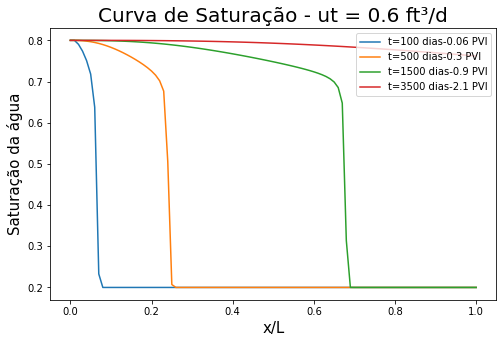

In [ ]:
#plotar os resultados
matriz_resultado_saturacao = np.insert(matriz_resultado_saturacao, 0, values = 0.8, axis=1) #Adicionando o ponto referente a condição de contorno
vetor_comprimento = np.linspace(0, 1, nx+1)
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
#ax.plot(vetor_comprimento, matriz_resultado_saturacao[9], label = "0.01 PVI")
ax.plot(vetor_comprimento, matriz_resultado_saturacao[9], label = "t=100 dias-0.06 PVI")
ax.plot(vetor_comprimento, matriz_resultado_saturacao[49], label = "t=500 dias-0.3 PVI")
ax.plot(vetor_comprimento, matriz_resultado_saturacao[149], label = "t=1500 dias-0.9 PVI")
ax.plot(vetor_comprimento, matriz_resultado_saturacao[349], label = "t=3500 dias-2.1 PVI")

ax.set_xlabel("x/L", fontsize=15)
ax.set_ylabel("Saturação da água", fontsize=15)
plt.title("Curva de Saturação - ut = 0.6 ft³/d", fontsize=20)
ax.legend(loc="upper right")
plt.show()

In [ ]:
pvi = ut*3500/(porosidade*tam_meio_poroso)
pvi

2.1

In [ ]:
t = (0.05*porosidade*tam_meio_poroso)/ut
t

83.33333333333334

### Construção da função visando usuário

In [ ]:
def explicit_saturation():

  #Discretização do domínio 
  
  nx = int(input("Digite o número de pontos do grid: "))                 #Número de pontos do grid
  dominio = np.arange(nx)                                                #vetor domínio
  print("Número de dimensões: {}".format(dominio.ndim))                  #número de dimensões
  print(dominio)

  #Calculo de Delta X

  #tamanho do meio poroso
  tam_meio_poroso = int(input("Digite o tamanho do reservatório em ft:"))
  #tamanho do elemento do grid
  tam_grid = tam_meio_poroso/nx
  #Delta X - normalizado
  dx = tam_grid/tam_meio_poroso
  print("") 
  print("O tamanho dos elementos do grid em uma malha estruturada é {}, e o delta X é {} ".format(tam_grid, dx))
  print("") 

  #Calculo de Delta T

  #viscosidade da água 
  visc_agua = float(input("Digite o valor da viscosidade da água em cp:"))
  #viscosidade do óleo
  visc_oleo = float(input("Digite o valor da viscosidade do óleo em cp:"))
  #velocidade total na injeção 
  ut = float(input("Digite o valor da velocidade total de injeção em ft³/d:"))
  #porosidade
  porosidade_meio = float(input("Entre com a porosidade do meio:"))
  #tempo de simulação 
  nt = int(input("Entre com os dias de injeção que será simulado:"))
  #passo de tempo
  passo_tempo = 10 #dias
  #Delta T - normalizado
  dt =  ut*passo_tempo/(tam_meio_poroso*porosidade_meio) #DÚVIDA: seria o passo de tempo ou o tempo total
  print("") 
  print("O delta T normalizado é {}".format(dt))

  #Número de Courant

  num_Courant = dt/dx
  print("") 
  print(f"O número de courant é {num_Courant}")

  #condição de contorno e inicial

  #Condição Inicial Sw(X,0)
  sw_CI = float(input("Entre com a condição de inicial (Sw):"))
  #Condição de Contorno Sw(0,T)
  sw_CC = float(input("Entre com a condição de contorno (Sw):"))
  #Matriz de saturação para alocação dos resultados
  tempos_de_injecao = int(nt/passo_tempo)   #quantidade representando os tempos de injeção que serão calculados
  matriz_resultado_saturacao = np.zeros((tempos_de_injecao,nx)) 
  print(f'A matriz saturação tem a seguinte forma {matriz_resultado_saturacao.shape}')

  #modificando a primeira linha da matriz para alocar os valores das condições iniciais
  matriz_resultado_saturacao[0,:] = sw_CI 

  #Características do sistema 

  #saturação inicial
  swi = float(input("Entre com a saturação de água inicial (Swi):"))
  #saturação de óleo residual
  sor = float(input("Entre com a saturação de óleo residual (Sor):"))
  #permeabilidade relativa da água na saturação residual
  krw_sor = float(input("Entre com a permeabilidade relativa da água no ponto terminal krw(Sor):"))
  #permeabilidade relativa do óleo na saturação residual
  kro_swi = float(input("Entre com a permeabilidade relativa do óleo no ponto terminal kro(Swi):"))
  #porosidade
  porosidade = porosidade_meio
  #parâmetros de Corey
  no = float(input("Insira o parâmetro de Corey (no):"))
  nw = float(input("Insira o parâmetro de Corey (nw):"))

  tempos_de_injecao = np.arange(tempos_de_injecao) #utilizado como vetor de tempo para o calculo de saturação
  print(f'Vetor com as iterações temporais: {tempos_de_injecao}')

  #Calculo da saturação e preenchimento da matriz de resultado

  #calulo do tempo de execução:
  start = timeit.default_timer()

  for n in tempos_de_injecao:
    #calculo da primeira linha
    if n == 0:
      for i in dominio:
        if i == 0: 
          #primeiro ponto
          mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
          mobilidade_i = mobilidade(sw_CI,visc_agua,visc_oleo)
          sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i) + sw_CI
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1
        else:
          #outros ponto
          sw_ajustado =  (matriz_resultado_saturacao[n,i-1] + matriz_resultado_saturacao[n,i])/2
          mobilidade_i_menos_meio = mobilidade(sw_ajustado,visc_agua,visc_oleo)
          mobilidade_i = mobilidade(sw_CI,visc_agua,visc_oleo)
          sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i) + sw_CI
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1
    #Cálculo das demais linhas      
    else:
        for i in dominio:
          if i == 0: 
            #primeiro ponto
            mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
            mobilidade_i = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo)
            sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i) + matriz_resultado_saturacao[n-1,i]
            matriz_resultado_saturacao[n,i] =  sw_n_mais_1
          else:
            #outros ponto
            sw_ajustado =  (matriz_resultado_saturacao[n-1,i-1] + matriz_resultado_saturacao[n-1,i])/2
            mobilidade_i_menos_meio = mobilidade(sw_ajustado,visc_agua,visc_oleo)
            mobilidade_i = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo)
            sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i) + matriz_resultado_saturacao[n-1,i]
            matriz_resultado_saturacao[n,i] =  sw_n_mais_1
  
  stop = timeit.default_timer()
  print('Tempo de execução: {} segundos'.format(stop-start))

  #plotar os resultados
  matriz_resultado_saturacao = np.insert(matriz_resultado_saturacao, 0, values = 0.8, axis=1) #Adicionando o ponto referente a condição de contorno
  vetor_comprimento = np.linspace(0, 1, nx+1)
  fig = plt.figure(figsize=(8,5))
  ax = plt.subplot(1,1,1)
  ax.plot(vetor_comprimento, matriz_resultado_saturacao[0], label = "0.006 PVI ")
  ax.plot(vetor_comprimento, matriz_resultado_saturacao[6], label = "0.042 PVI")
  ax.plot(vetor_comprimento, matriz_resultado_saturacao[20], label = "0.126 PVI")
  ax.plot(vetor_comprimento, matriz_resultado_saturacao[35], label = "0.216 PVI")
  ax.plot(vetor_comprimento, matriz_resultado_saturacao[71], label = "0.432 PVI")

  ax.set_xlabel("x/L", fontsize=15)
  ax.set_ylabel("Saturação da água", fontsize=15)
  plt.title("Curva de Saturação", fontsize=20)
  ax.legend()
  plt.show()

  return

In [ ]:
#explicit_saturation()

## Comparação com o Excel

In [ ]:
#Discretização do domínio 
nx = 15                                                               #Número de pontos do grid
dominio = np.arange(nx)                                                #vetor domínio
print("Número de dimensões: {}".format(dominio.ndim))                  #número de dimensões
print(dominio)

Número de dimensões: 1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [ ]:
#Calculo de Delta X
#tamanho do meio poroso
tam_meio_poroso = 5000 #ft
#tamanho do elemento do grid
tam_grid = tam_meio_poroso/nx
#Delta X - normalizado
dx = tam_grid/tam_meio_poroso
print("O tamanho dos elementos do grid em uma malha estruturada é {}, e o delta X é {} ".format(tam_grid, dx))

O tamanho dos elementos do grid em uma malha estruturada é 333.3333333333333, e o delta X é 0.06666666666666667 


In [ ]:
#Calculo de Delta T
#viscosidade da água 
visc_agua = 0.5963 #cp
#viscosidade do óleo
visc_oleo = 2 #cp
#velocidade total na injeção 
ut = 1 #ft³/d - AVALIAR DEPOIS
#porosidade
porosidade_meio = 0.2
#tempo de simulação 
nt = 365 #dias
#passo de tempo
passo_tempo = 10 #dias
#Delta T - normalizado
dt =  ut*passo_tempo/(tam_meio_poroso*porosidade_meio) #DÚVIDA: seria o passo de tempo ou o tempo total
print("O delta T normalizado é {}".format(dt))

O delta T normalizado é 0.01


In [ ]:
#Número de Courant
num_Courant = dt/dx # ANALISE DE SENSIBILIDADE DEPOIS
print(f"O número de courant é {num_Courant}")

O número de courant é 0.15


In [ ]:
#condição de contorno e inicial
#Condição Inicial Sw(X,0)
sw_CI = 0.2
#Condição de Contorno Sw(0,T)
sw_CC = 0.8
#Matriz de saturação para alocação dos resultados
tempos_de_injecao = int(nt/passo_tempo)   #quantidade representando os tempos de injeção que serão calculados
matriz_resultado_saturacao = np.zeros((tempos_de_injecao,nx)) 
matriz_resultado_saturacao.shape

(36, 15)

In [ ]:
#modificando a primeira linha da matriz para alocar os valores das condições iniciais
matriz_resultado_saturacao[0,:] = sw_CI 

In [ ]:
matriz_resultado_saturacao[0]

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2])

In [ ]:
#Características do sistema molhável a água
#saturação inicial
swi = 0.2
#saturação de óleo residual
sor = 0.2
#permeabilidade relativa da água na saturação residual
krw_sor = 0.3 
#permeabilidade relativa do óleo na saturação residual
kro_swi = 0.99 
#porosidade
porosidade = porosidade_meio
#parâmetros de Corey
no = 1.0
nw = 2

In [ ]:
tempos_de_injecao = np.arange(tempos_de_injecao) #utilizado como vetor de tempo para o calculo de saturação
tempos_de_injecao

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [ ]:
#Calculo da saturação e preenchimento da matriz de resultado
#calulo do tempo de execução:
start = timeit.default_timer()
for n in tempos_de_injecao:
  #calculo da primeira linha
  if n == 0:
    for i in dominio:
      if i == 0: 
        #primeiro ponto
        mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
        mobilidade_i = mobilidade(sw_CC,visc_agua,visc_oleo)
        sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i) + sw_CC
        matriz_resultado_saturacao[n,i] =  sw_n_mais_1
      else:
        #outros ponto
        sw_ajustado =  matriz_resultado_saturacao[n,i-1] 
        mobilidade_i_menos_meio = mobilidade(sw_ajustado,visc_agua,visc_oleo)
        mobilidade_i = mobilidade(sw_CI,visc_agua,visc_oleo)
        sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i) + sw_CI
        matriz_resultado_saturacao[n,i] =  sw_n_mais_1
  #Cálculo das demais linhas      
  else:
      for i in dominio:
        if i == 0: 
          #primeiro ponto
          mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
          mobilidade_i = mobilidade(sw_CC,visc_agua,visc_oleo)
          sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i) + matriz_resultado_saturacao[n-1,i]
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1
        else:
          #outros ponto
          sw_ajustado =  matriz_resultado_saturacao[n-1,i-1] 
          mobilidade_i_menos_meio = mobilidade(sw_ajustado,visc_agua,visc_oleo)
          mobilidade_i = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo)
          sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i) + matriz_resultado_saturacao[n-1,i]
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1
stop = timeit.default_timer()
print('Tempo de execução: {} segundos'.format(stop-start))

Tempo de execução: 0.046726996999495896 segundos


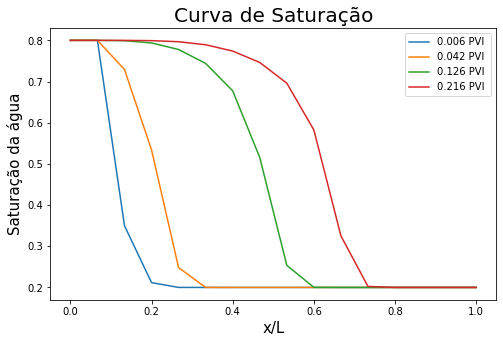

In [ ]:
#plotar os resultados
matriz_resultado_saturacao = np.insert(matriz_resultado_saturacao, 0, values = 0.8, axis=1) #Adicionando o ponto referente a condição de contorno
vetor_comprimento = np.linspace(0, 1, nx+1)
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(vetor_comprimento, matriz_resultado_saturacao[0], label = "0.006 PVI ")
ax.plot(vetor_comprimento, matriz_resultado_saturacao[5], label = "0.042 PVI")
ax.plot(vetor_comprimento, matriz_resultado_saturacao[20], label = "0.126 PVI")
ax.plot(vetor_comprimento, matriz_resultado_saturacao[29], label = "0.216 PVI")
#ax.plot(vetor_comprimento, matriz_resultado_saturacao[71], label = "0.432 PVI")

ax.set_xlabel("x/L", fontsize=15)
ax.set_ylabel("Saturação da água", fontsize=15)
plt.title("Curva de Saturação", fontsize=20)
ax.legend()
plt.show()

In [ ]:
matriz_resultado_saturacao[1]

array([0.8       , 0.8       , 0.48828742, 0.22336594, 0.20011846,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       ])

In [ ]:
def explicit_saturation_excel():

  #Discretização do domínio 
  
  nx = int(input("Digite o número de pontos do grid: "))                 #Número de pontos do grid
  dominio = np.arange(nx)                                                #vetor domínio
  print("Número de dimensões: {}".format(dominio.ndim))                  #número de dimensões
  print(dominio)

  #Calculo de Delta X

  #tamanho do meio poroso
  tam_meio_poroso = int(input("Digite o tamanho do reservatório em ft:"))
  #tamanho do elemento do grid
  tam_grid = tam_meio_poroso/nx
  #Delta X - normalizado
  dx = tam_grid/tam_meio_poroso
  print("") 
  print("O tamanho dos elementos do grid em uma malha estruturada é {}, e o delta X é {} ".format(tam_grid, dx))
  print("") 

  #Calculo de Delta T

  #viscosidade da água 
  visc_agua = float(input("Digite o valor da viscosidade da água em cp:"))
  #viscosidade do óleo
  visc_oleo = float(input("Digite o valor da viscosidade do óleo em cp:"))
  #velocidade total na injeção 
  ut = float(input("Digite o valor da velocidade total de injeção em ft³/d:"))
  #porosidade
  porosidade_meio = float(input("Entre com a porosidade do meio:"))
  #tempo de simulação 
  nt = int(input("Entre com os dias de injeção que será simulado:"))
  #passo de tempo
  passo_tempo = 10 #dias
  #Delta T - normalizado
  dt =  ut*passo_tempo/(tam_meio_poroso*porosidade_meio) #DÚVIDA: seria o passo de tempo ou o tempo total
  print("") 
  print("O delta T normalizado é {}".format(dt))

  #Número de Courant

  num_Courant = dt/dx
  print("") 
  print(f"O número de courant é {num_Courant}")
  print("")

  #condição de contorno e inicial

  #Condição Inicial Sw(X,0)
  sw_CI = float(input("Entre com a condição de inicial (Sw):"))
  #Condição de Contorno Sw(0,T)
  sw_CC = float(input("Entre com a condição de contorno (Sw):"))
  #Matriz de saturação para alocação dos resultados
  tempos_de_injecao = int(nt/passo_tempo)   #quantidade representando os tempos de injeção que serão calculados
  matriz_resultado_saturacao = np.zeros((tempos_de_injecao,nx)) 
  print("")
  print(f'A matriz saturação tem a seguinte forma {matriz_resultado_saturacao.shape}')
  print("")

  #modificando a primeira linha da matriz para alocar os valores das condições iniciais
  matriz_resultado_saturacao[0,:] = sw_CI 

  #Características do sistema 

  #saturação inicial
  swi = float(input("Entre com a saturação de água inicial (Swi):"))
  #saturação de óleo residual
  sor = float(input("Entre com a saturação de óleo residual (Sor):"))
  #permeabilidade relativa da água na saturação residual
  krw_sor = float(input("Entre com a permeabilidade relativa da água no ponto terminal krw(Sor):"))
  #permeabilidade relativa do óleo na saturação residual
  kro_swi = float(input("Entre com a permeabilidade relativa do óleo no ponto terminal kro(Swi):"))
  #porosidade
  porosidade = porosidade_meio
  #parâmetros de Corey
  no = float(input("Insira o parâmetro de Corey (no):"))
  nw = float(input("Insira o parâmetro de Corey (nw):"))

  tempos_de_injecao = np.arange(tempos_de_injecao) #utilizado como vetor de tempo para o calculo de saturação
  print("")
  print(f'Vetor com as iterações temporais: {tempos_de_injecao}')
  print("")

  #Calculo da saturação e preenchimento da matriz de resultado

  #calulo do tempo de execução:
  start = timeit.default_timer()

  for n in tempos_de_injecao:
    #calculo da primeira linha
    if n == 0:
      for i in dominio:
        if i == 0: 
          #primeiro ponto
          mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
          mobilidade_i = mobilidade(sw_CC,visc_agua,visc_oleo)
          sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i) + sw_CC
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1
        else:
          #outros ponto
          sw_ajustado =  matriz_resultado_saturacao[n,i-1] 
          mobilidade_i_menos_meio = mobilidade(sw_ajustado,visc_agua,visc_oleo)
          mobilidade_i = mobilidade(sw_CI,visc_agua,visc_oleo)
          sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i) + sw_CI
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1
    #Cálculo das demais linhas      
    else:
        for i in dominio:
          if i == 0: 
            #primeiro ponto
            mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
            mobilidade_i = mobilidade(sw_CC,visc_agua,visc_oleo)
            sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i) + matriz_resultado_saturacao[n-1,i]
            matriz_resultado_saturacao[n,i] =  sw_n_mais_1
          else:
            #outros ponto
            sw_ajustado =  matriz_resultado_saturacao[n-1,i-1] 
            mobilidade_i_menos_meio = mobilidade(sw_ajustado,visc_agua,visc_oleo)
            mobilidade_i = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo)
            sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i) + matriz_resultado_saturacao[n-1,i]
            matriz_resultado_saturacao[n,i] =  sw_n_mais_1
  
  stop = timeit.default_timer()
  print("")
  print('Tempo de execução: {} segundos'.format(stop-start))
  print("")

  #plotar os resultados
  vetor_comprimento = np.linspace(0, 1, nx)
  fig = plt.figure(figsize=(8,5))
  ax = plt.subplot(1,1,1)
  ax.plot(vetor_comprimento, matriz_resultado_saturacao[0], label = "0.006 PVI ")
  ax.plot(vetor_comprimento, matriz_resultado_saturacao[5], label = "0.042 PVI")
  ax.plot(vetor_comprimento, matriz_resultado_saturacao[20], label = "0.126 PVI")
  ax.plot(vetor_comprimento, matriz_resultado_saturacao[29], label = "0.216 PVI")
  #ax.plot(vetor_comprimento, matriz_resultado_saturacao[71], label = "0.432 PVI")

  ax.set_xlabel("x/L", fontsize=15)
  ax.set_ylabel("Saturação da água", fontsize=15)
  plt.title("Curva de Saturação", fontsize=20)
  ax.legend()
  plt.show()

  return

## Programa Corrigido - single point upstream

In [ ]:
#Calculo da saturação explicitamente utilizando o método single point upstream (ϕ=0)
#calulo do tempo de execução:
start = timeit.default_timer()
for n in tempos_de_injecao:
  #calculo da primeira linha
  if n == 0:
    for i in dominio:
      if i == 0: 
        #primeiro ponto
        mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
        mobilidade_i = mobilidade(sw_CI,visc_agua,visc_oleo)
        sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i) + sw_CI
        matriz_resultado_saturacao[n,i] =  sw_n_mais_1
      else:
        #outros ponto
        sw_ajustado =  sw_CI
        mobilidade_i_menos_meio = mobilidade(sw_ajustado,visc_agua,visc_oleo)
        mobilidade_i = mobilidade(sw_CI,visc_agua,visc_oleo)
        sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i) + sw_CI
        matriz_resultado_saturacao[n,i] =  sw_n_mais_1
  #Cálculo das demais linhas      
  else:
      for i in dominio:
        if i == 0: 
          #primeiro ponto
          mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
          mobilidade_i = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo)
          sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i) + matriz_resultado_saturacao[n-1,i]
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1
        else:
          #outros ponto
          sw_ajustado =  matriz_resultado_saturacao[n-1,i-1] 
          mobilidade_i_menos_meio = mobilidade(sw_ajustado,visc_agua,visc_oleo)
          mobilidade_i = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo)
          sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i) + matriz_resultado_saturacao[n-1,i]
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1
matriz_resultado_saturacao_single_point = matriz_resultado_saturacao
stop = timeit.default_timer()
print('Tempo de execução: {} segundos'.format(stop-start))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


Tempo de execução: 2.2489273969999886 segundos


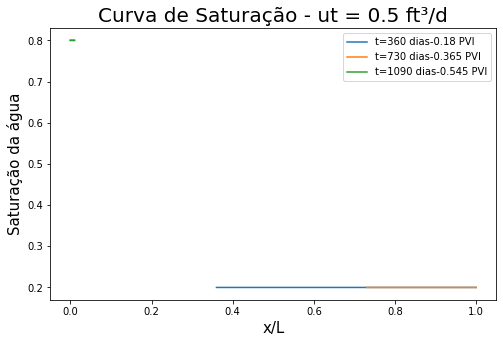

In [ ]:
#plotar os resultados
matriz_resultado_saturacao_single_point = np.insert(matriz_resultado_saturacao_single_point, 0, values = 0.8, axis=1) #Adicionando o ponto referente a condição de contorno
vetor_comprimento = np.linspace(0, 1, nx+1)
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)

#PVI utilizados nos labels
td_label_1= ut*360/(tam_meio_poroso*porosidade_meio)
td_label_2= ut*730/(tam_meio_poroso*porosidade_meio)
td_label_3= ut*1090/(tam_meio_poroso*porosidade_meio)
td_label_4= ut*1820/(tam_meio_poroso*porosidade_meio)

ax.plot(vetor_comprimento, matriz_resultado_saturacao_single_point[35], label = "t=360 dias-{} PVI".format(td_label_1))
ax.plot(vetor_comprimento, matriz_resultado_saturacao_single_point[72], label = "t=730 dias-{} PVI".format(td_label_2))
ax.plot(vetor_comprimento, matriz_resultado_saturacao_single_point[108], label = "t=1090 dias-{} PVI".format(td_label_3))
#ax.plot(vetor_comprimento, matriz_resultado_saturacao_single_point[181], label = "t=1820 dias-{} PVI".format(td_label_4))


ax.set_xlabel("x/L", fontsize=15)
ax.set_ylabel("Saturação da água", fontsize=15)
plt.title("Curva de Saturação - ut = {} ft³/d".format(ut), fontsize=20)
ax.legend(loc="upper right")
plt.show()

## Programa Corrigido - Limitador de fluxo TVD

In [143]:
#função para o cálculo de ajuste de fluxo

def funcao_limitador(sw_i,sw_i_mais_um,sw_i_menos_um):
  numerador = mobilidade(sw_i,visc_agua,visc_oleo) - mobilidade(sw_i_menos_um,visc_agua,visc_oleo)
  denominador = mobilidade(sw_i_mais_um,visc_agua,visc_oleo)-mobilidade(sw_i,visc_agua,visc_oleo)
  if denominador == 0:
    r = 1
  else:
    r = numerador/denominador
  return r

def ajuste_fluxo(limitador_van_leer, sw_um, sw_dois):
  func_ajuste_fluxo = limitador_van_leer/2*(mobilidade(sw_um,visc_agua,visc_oleo) - mobilidade(sw_dois,visc_agua,visc_oleo))*(1-num_Courant)

  return func_ajuste_fluxo

def van_leer(r):
  if (1+r) == 0:
    fi = 1
  else:
    fi = (r+abs(r))/(1+r)
  return fi

In [169]:
#Cálculo da saturação explicitamente utilizando o método two point upstream (ϕ=r)

#calulo do tempo de execução:
start = timeit.default_timer()

for n in tempos_de_injecao:

  #cálculo da primeira linha
  
  if n == 0:

    for i in dominio:
      if i == 0: 

        #primeiro ponto
        mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)

        #cálculo do limitador de Van Leer para o primeiro ponto
        #cálculo da função r para o primeiro ponto
        r = funcao_limitador(sw_CI,sw_CI,sw_CC)
        limitador_van_leer = van_leer(r)

        #cálculo do fluxo ajustado 
        mobilidade_i_mais_meio = mobilidade(sw_CI,visc_agua,visc_oleo) + ajuste_fluxo(limitador_van_leer,sw_CI,sw_CI) 

        #auxiliar que grava o valor do fluxo de i+1/2
        #que para próximo ponto, o fluxo i-1/2 terá o mesmo valor do auxiliar
        aux = mobilidade_i_mais_meio 
        
        #cálculo da saturação no novo passo de tempo (n+1)
        sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i_mais_meio) + sw_CI
        
        #salvando os valores na matriz resultado
        matriz_resultado_saturacao[n,i] =  sw_n_mais_1

      else:
        #outros pontos

        sw_ajustado =  sw_CI

        #cálculo do limitador de Van Leer para os demais pontos
        r = funcao_limitador(sw_CI,sw_CI,sw_CI)
        limitador_van_leer = van_leer(r)

        #Fi-1/2 = Fi-1 + limitador/2*(Fi-Fi-1)
        #mobilidade_i_menos_meio = mobilidade(sw_ajustado,visc_agua,visc_oleo) + ajuste_fluxo(limitador_van_leer,sw_CI,sw_CI) 
        mobilidade_i_menos_meio = aux

        #Fi+1/2 = Fi + limitador/2*(Fi+1-Fi)
        mobilidade_i_mais_meio = mobilidade(sw_CI,visc_agua,visc_oleo) + ajuste_fluxo(limitador_van_leer,sw_CI,sw_CI)
        
        #cálculo da saturação no novo passo de tempo (n+1)
        sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i_mais_meio) + sw_CI
        
        #salvando os valores na matriz resultado
        matriz_resultado_saturacao[n,i] =  sw_n_mais_1

        #auxiliar para guardar o valor do fluxo na face do volume de controle
        aux = mobilidade_i_mais_meio

  #Cálculo das demais linhas      
  else:

      for i in dominio:
        
        if i == 0: 
          
          #primeiro ponto
          mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)

          #cálculo do limitador
          r = funcao_limitador(matriz_resultado_saturacao[n-1,i],matriz_resultado_saturacao[n-1,i+1],matriz_resultado_saturacao[n-1,i-1])
          limitador_van_leer = van_leer(r)
          
          #Fi+1/2 = Fi + limitador/2*(Fi+1-Fi)
          mobilidade_i_mais_meio = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo) + ajuste_fluxo(limitador_van_leer,matriz_resultado_saturacao[n-1,i+1],matriz_resultado_saturacao[n-1,i])
          
          #cálculo da saturação no novo passo de tempo (n+1)
          sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i_mais_meio) + matriz_resultado_saturacao[n-1,i]

          #configurando a saturação para atingir valores entre 1-sor e swi
          #sw_n_mais_1 = np.array([1-sor if sw_n_mais_1 >= (1-sor) else sw_n_mais_1])
          #sw_n_mais_1 = np.array([swi if sw_n_mais_1 <= swi else sw_n_mais_1])
          
          #salvando os valores na matriz resultado
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1

          #auxiliar para guardar o valor do fluxo na face do volume de controle
          aux = mobilidade_i_mais_meio
        
        else:
          
          #outros pontos

          #sw_ajustado =  matriz_resultado_saturacao[n-1,i-1]
          
          #cálculo do limitador
          if i == nx-1:
            r = funcao_limitador(matriz_resultado_saturacao[n-1,i],sw_CI,matriz_resultado_saturacao[n-1,i-1])
            limitador_van_leer = van_leer(r)
          else:
            r = funcao_limitador(matriz_resultado_saturacao[n-1,i],matriz_resultado_saturacao[n-1,i+1],matriz_resultado_saturacao[n-1,i-1]) 
            limitador_van_leer = van_leer(r)

          #Fi-1/2 = Fi-1 + limitador/2*(Fi-Fi-1)
          mobilidade_i_menos_meio = aux

          #Fi+1/2 = Fi + limitador/2*(Fi+1-Fi)
          
          #condição para quando chegar na fronteira de saída do domínio
          if i == nx-1:
            mobilidade_i_mais_meio = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo) + ajuste_fluxo(limitador_van_leer,sw_CI,matriz_resultado_saturacao[n-1,i])
          else:
            mobilidade_i_mais_meio = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo) + ajuste_fluxo(limitador_van_leer,matriz_resultado_saturacao[n-1,i+1],matriz_resultado_saturacao[n-1,i])
          
          #cálculo da saturação no novo passo de tempo (n+1)
          sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i_mais_meio) + matriz_resultado_saturacao[n-1,i]

          #configurando a saturação para atingir valores entre 1-sor e swi
          #sw_n_mais_1 = np.array([1-sor if sw_n_mais_1 >= (1-sor) else sw_n_mais_1])
          #sw_n_mais_1 = np.array([swi if sw_n_mais_1 <= swi else sw_n_mais_1])

          #salvando os valores na matriz resultado
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1

          #auxiliar para guardar o valor do fluxo na face do volume de controle
          aux = mobilidade_i_mais_meio

#salvando a matriz com nome específico para poder realizar análises comparativas
matriz_resultado_saturacao_two_point = matriz_resultado_saturacao

#tempo de execução finalizado
stop = timeit.default_timer()

print('Tempo de execução: {} segundos'.format(stop-start))

Tempo de execução: 9.037374732999524 segundos


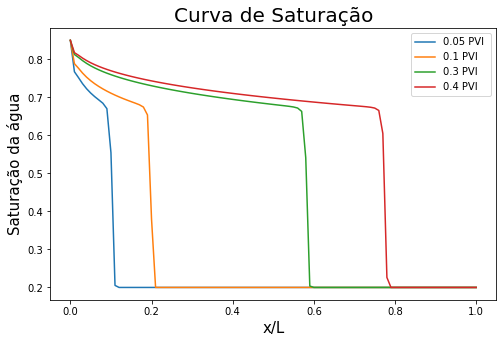

In [172]:
#plotar os resultados 
matriz_resultado_saturacao_two_point = np.insert(matriz_resultado_saturacao_two_point, 0, values = sw_CC, axis=1) #Adicionando o ponto referente a condição de contorno
vetor_comprimento = np.linspace(0, 1, nx+1)
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(vetor_comprimento, matriz_resultado_saturacao_two_point[49], label = "0.05 PVI ") 
ax.plot(vetor_comprimento, matriz_resultado_saturacao_two_point[99], label = "0.1 PVI")
ax.plot(vetor_comprimento, matriz_resultado_saturacao_two_point[299], label = "0.3 PVI")
ax.plot(vetor_comprimento, matriz_resultado_saturacao_two_point[399], label = "0.4 PVI")


ax.set_xlabel("x/L", fontsize=15)
ax.set_ylabel("Saturação da água", fontsize=15)
plt.title("Curva de Saturação", fontsize=20)
ax.legend()
plt.show()

## Programa Corrigido - midpoint e downstream

In [12]:
#função para o cálculo de ajuste de fluxo

def ajuste_fluxo(limitador_van_leer, sw_um, sw_dois):
  func_ajuste_fluxo = limitador_van_leer/2*(mobilidade(sw_um,visc_agua,visc_oleo) - mobilidade(sw_dois,visc_agua,visc_oleo))*(1-num_Courant)

  return func_ajuste_fluxo

In [65]:
#Cálculo da saturação explicitamente utilizando o método midpoint (ϕ=1) e downstream (ϕ=2)

#calulo do tempo de execução:
start = timeit.default_timer()

#limitador de Van Leer 
limitador_van_leer = 1

for n in tempos_de_injecao:

  #calculo da primeira linha
  
  if n == 0:

    for i in dominio:
      if i == 0: 

        #primeiro ponto
        
        mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
        
        #cálculo do fluxo ajustado 
        mobilidade_i_mais_meio = mobilidade(sw_CI,visc_agua,visc_oleo) + ajuste_fluxo(limitador_van_leer,sw_CI,sw_CI) 
        
        #auxiliar que grava o valor do fluxo de i+1/2
        #que para próximo ponto, o fluxo i-1/2 terá o mesmo valor do auxiliar
        aux = mobilidade_i_mais_meio 
        
        #cálculo da saturação no novo passo de tempo (n+1)
        sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i_mais_meio) + sw_CI

        #salvando os valores na matriz resultado
        matriz_resultado_saturacao[n,i] =  sw_n_mais_1

      else:
        
        #outros ponto
        
        sw_ajustado =  sw_CI
        
        #Fi-1/2 = Fi-1 + limitador/2*(Fi-Fi-1)
        
        mobilidade_i_menos_meio = aux
        
        #Fi+1/2 = Fi + limitador/2*(Fi+1-Fi)
        mobilidade_i_mais_meio = mobilidade(sw_CI,visc_agua,visc_oleo) + ajuste_fluxo(limitador_van_leer,sw_CI,sw_CI)

        #cálculo da saturação no novo passo de tempo (n+1)
        sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i_mais_meio) + sw_CI

        #salvando os valores na matriz resultado
        matriz_resultado_saturacao[n,i] =  sw_n_mais_1

        #auxiliar para guardar o valor do fluxo na face do volume de controle
        aux = mobilidade_i_mais_meio

  #Cálculo das demais linhas      
  else:

      for i in dominio:
        
        if i == 0: 
          
          #primeiro ponto
          
          mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
          
          #Fi+1/2 = Fi + limitador/2*(Fi+1-Fi)
          mobilidade_i_mais_meio = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo) + ajuste_fluxo(limitador_van_leer,matriz_resultado_saturacao[n-1,i+1],matriz_resultado_saturacao[n-1,i])
          
          #cálculo da saturação no novo passo de tempo (n+1)
          sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i_mais_meio) + matriz_resultado_saturacao[n-1,i]
          
          #configurando a saturação para atingir valores até 1-sor
          sw_n_mais_1 = np.array([1-sor if sw_n_mais_1 >= (1-sor) else sw_n_mais_1])

          #salvando os valores na matriz resultado
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1
          
          #auxiliar para guardar o valor do fluxo na face do volume de controle
          aux = mobilidade_i_mais_meio

        else:

          #outros ponto
          
          #sw_ajustado =  matriz_resultado_saturacao[n-1,i-1]
          
          #Fi-1/2 = Fi-1 + limitador/2*(Fi-Fi-1)
          mobilidade_i_menos_meio = aux

          #Fi+1/2 = Fi + limitador/2*(Fi+1-Fi)
          #condição para quando chegar na fronteira de saída do domínio
          if i == nx-1:
            mobilidade_i_mais_meio = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo) + ajuste_fluxo(limitador_van_leer,matriz_resultado_saturacao[n-1,i],matriz_resultado_saturacao[n-1,i])
          else:
            mobilidade_i_mais_meio = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo) + ajuste_fluxo(limitador_van_leer,matriz_resultado_saturacao[n-1,i+1],matriz_resultado_saturacao[n-1,i])
          
          #cálculo da saturação
          sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i_mais_meio) + matriz_resultado_saturacao[n-1,i]
          
          #configurando a saturação para atingir valores até 1-sor
          sw_n_mais_1 = np.array([1-sor if sw_n_mais_1 >= (1-sor) else sw_n_mais_1])

          #salvando os valores na matriz resultado
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1

          #auxiliar para guardar o valor do fluxo na face do volume de controle
          aux = mobilidade_i_mais_meio

#salvando a matriz com nome específico para poder realizar análises comparativas
matriz_resultado_saturacao_mid_down = matriz_resultado_saturacao

#tempo de execução finalizado
stop = timeit.default_timer()

print('Tempo de execução: {} segundos'.format(stop-start))

Tempo de execução: 0.47957641300001796 segundos


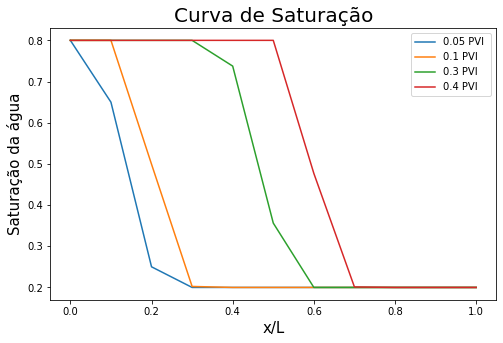

In [66]:
#plotar os resultados 
matriz_resultado_saturacao_mid_down = np.insert(matriz_resultado_saturacao_mid_down, 0, values = sw_CC, axis=1) #Adicionando o ponto referente a condição de contorno
vetor_comprimento = np.linspace(0, 1, nx+1)
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(vetor_comprimento, matriz_resultado_saturacao_mid_down[49], label = "0.05 PVI ") 
ax.plot(vetor_comprimento, matriz_resultado_saturacao_mid_down[99], label = "0.1 PVI")
ax.plot(vetor_comprimento, matriz_resultado_saturacao_mid_down[299], label = "0.3 PVI")
ax.plot(vetor_comprimento, matriz_resultado_saturacao_mid_down[399], label = "0.4 PVI")


ax.set_xlabel("x/L", fontsize=15)
ax.set_ylabel("Saturação da água", fontsize=15)
plt.title("Curva de Saturação", fontsize=20)
ax.legend()
plt.show()

In [15]:
mobilidade_i_mais_meio = mobilidade(sw_CI,visc_agua,visc_oleo) + ajuste_fluxo(limitador_van_leer,sw_CI,sw_CI)
mobilidade_i_mais_meio 

array([0.])

In [28]:
matriz_resultado_saturacao_mid_down[399]

array([0.8       , 0.8       , 0.8       , 0.8       , 0.8       ,
       0.8       , 0.8       , 0.8       , 0.8       , 0.8       ,
       0.8       , 0.8       , 0.8       , 0.8       , 0.8       ,
       0.8       , 0.8       , 0.8       , 0.8       , 0.8       ,
       0.8       , 0.8       , 0.8       , 0.8       , 0.8       ,
       0.8       , 0.8       , 0.55303703, 0.20833068, 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       ])

## Validação

### Artigo I - Mathematical modeling of oil recovery

In [146]:
#dados do artigo
#ut = 1
#porosidade = 1
sw_CI = 0.2
sw_CC = 0.85
#L=10000 m
#t=2000 dias


In [147]:
sor = 1-sw_CC
swi = sw_CI
krw_sor = ((1-sor-0.2)/0.8)**3.5
kro_swi = ((0.85-swi)/0.85)**2.8*(1+2.4*swi)
print(krw_sor, kro_swi)

0.48348365186733283 0.6983065601690129


In [148]:
#função para o cálculo do modelo utilizado no artigo

def perm_validacao(sw,swi,sor,kro_swi,krw_sor):
  kro = []
  krw = []

  if isinstance(sw, Iterable):
    #cálculo da permeabilidade relativa do óleo 
    for i in sw:
        kr = ((0.85-i)/0.85)**2.8*(1+2.4*i)
        kro.append(kr)
    kro = np.array([kro_swi if i >= 1 else i for i in kro]) #substituindo o valor 1 por kro_swi
    kro[-1] = 0.0 # solução temporária para o erro 

    #cálculo da permeabilidade relativa da água
    for i in sw:
        kr = ((i-0.2)/0.8)**3.5
        if kr > krw_sor:
          kr = krw_sor
        krw.append(kr)
    krw = np.array(krw)


  else:
    #cálculo da permeabilidade relativa do óleo
    if (0.85 <= sw <= 1):
      kr = 0
    else: 
      kr = ((0.85-sw)/0.85)**2.8*(1+2.4*sw)
    kro.append(kr)
    kro = np.array(kro) 
    #cálculo da permeabilidade relativa da água 
    if (0 <= sw <= 0.2):
      kr = 0
    else:
      kr = ((sw-0.2)/0.8)**3.5
    krw.append(kr)
    krw = np.array(krw)
  
  return kro, krw

#função que calcula a mobilidade em diferentes pontos de saturação
def mobilidade(sw,visc_agua,visc_oleo):

  numerador_da_funcao = perm_validacao(sw,swi,sor,kro_swi,krw_sor)[1]/visc_agua
  denominador_da_funcao = (perm_validacao(sw,swi,sor,kro_swi,krw_sor)[1]/visc_agua) + (perm_validacao(sw,swi,sor,kro_swi,krw_sor)[0]/visc_oleo)
  resultado_mobilidade =  numerador_da_funcao/denominador_da_funcao

  return resultado_mobilidade

In [149]:
#Discretização do domínio 
nx = 100                                                              #Número de pontos do grid
dominio = np.arange(nx)                                                #vetor domínio
print("Número de dimensões: {}".format(dominio.ndim))                  #número de dimensões
print(dominio)

Número de dimensões: 1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [150]:
#Calculo de Delta X
#tamanho do meio poroso
tam_meio_poroso = 10000 #m
#tamanho do elemento do grid
tam_grid = tam_meio_poroso/nx
#Delta X - normalizado
dx = tam_grid/tam_meio_poroso
print("O tamanho dos elementos do grid em uma malha estruturada é {}, e o delta X é {} ".format(tam_grid, dx))

O tamanho dos elementos do grid em uma malha estruturada é 100.0, e o delta X é 0.01 


In [151]:
#Calculo de Delta T
#viscosidade da água 
visc_agua = 0.5 #cp
#viscosidade do óleo
visc_oleo = 1 #cp
#muo = visc_oleo/visc_agua = 2
#velocidade total na injeção 
ut = 1 #m³/d 
#porosidade
porosidade_meio = 1
#tempo de simulação 
nt = 4000 #dias
#passo de tempo
passo_tempo = 10 #dias
#Delta T - normalizado
dt =  ut*passo_tempo/(tam_meio_poroso*porosidade_meio) 
print("O delta T normalizado é {}".format(dt))

O delta T normalizado é 0.001


In [152]:
#Número de Courant
num_Courant = dt/dx 
print(f"O número de courant é {num_Courant}")

O número de courant é 0.1


In [165]:
#Matriz de saturação para alocação dos resultados
tempos_de_injecao = int(nt/passo_tempo)   #quantidade representando os tempos de injeção que serão calculados
matriz_resultado_saturacao = np.zeros((tempos_de_injecao,nx)) 
matriz_resultado_saturacao.shape

(400, 100)

In [166]:
#modificando a primeira linha da matriz para alocar os valores das condições iniciais
matriz_resultado_saturacao[0,:] = sw_CI 

In [167]:
matriz_resultado_saturacao[0]

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

In [168]:
tempos_de_injecao = np.arange(tempos_de_injecao) #utilizado como vetor de tempo para o calculo de saturação
tempos_de_injecao

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [157]:
#Calculo da saturação explicitamente utilizando o método single point upstream (ϕ=0)
#calulo do tempo de execução:
start = timeit.default_timer()
for n in tempos_de_injecao:
  #calculo da primeira linha
  if n == 0:
    for i in dominio:
      if i == 0: 
        #primeiro ponto
        mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
        mobilidade_i = mobilidade(sw_CI,visc_agua,visc_oleo)
        sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i) + sw_CI
        matriz_resultado_saturacao[n,i] =  sw_n_mais_1
      else:
        #outros ponto
        sw_ajustado =  sw_CI
        mobilidade_i_menos_meio = mobilidade(sw_ajustado,visc_agua,visc_oleo)
        mobilidade_i = mobilidade(sw_CI,visc_agua,visc_oleo)
        sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i) + sw_CI
        matriz_resultado_saturacao[n,i] =  sw_n_mais_1
  #Cálculo das demais linhas      
  else:
      for i in dominio:
        if i == 0: 
          #primeiro ponto
          mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
          mobilidade_i = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo)
          sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i) + matriz_resultado_saturacao[n-1,i]
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1
        else:
          #outros ponto
          sw_ajustado =  matriz_resultado_saturacao[n-1,i-1] 
          mobilidade_i_menos_meio = mobilidade(sw_ajustado,visc_agua,visc_oleo)
          mobilidade_i = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo)
          sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i) + matriz_resultado_saturacao[n-1,i]
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1
matriz_resultado_saturacao_validacao_I = matriz_resultado_saturacao 
stop = timeit.default_timer()
print('Tempo de execução: {} segundos'.format(stop-start))

Tempo de execução: 2.6533295509998425 segundos


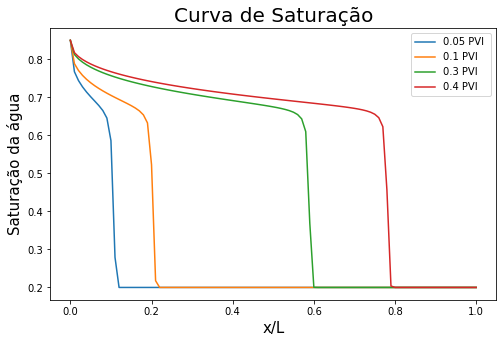

In [158]:
#plotar os resultados algoritmo I
matriz_resultado_saturacao_validacao_I = np.insert(matriz_resultado_saturacao_validacao_I, 0, values = sw_CC, axis=1) #Adicionando o ponto referente a condição de contorno
vetor_comprimento = np.linspace(0, 1, nx+1)
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_I[49], label = "0.05 PVI ") 
ax.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_I[99], label = "0.1 PVI")
ax.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_I[299], label = "0.3 PVI")
ax.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_I[399], label = "0.4 PVI")
#ax.plot(vetor_comprimento, matriz_resultado_saturacao[71], label = "0.432 PVI")

ax.set_xlabel("x/L", fontsize=15)
ax.set_ylabel("Saturação da água", fontsize=15)
plt.title("Curva de Saturação", fontsize=20)
ax.legend()
plt.show()

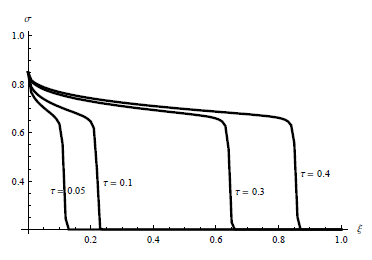

In [ ]:
pvi = ut*3000/(porosidade_meio*tam_meio_poroso)
pvi

0.3

In [ ]:
t = (0.4*porosidade_meio*tam_meio_poroso)/ut
t

4000.0

In [163]:
#Calculo da saturação e preenchimento da matriz de resultado
#calulo do tempo de execução:
start = timeit.default_timer()
for n in tempos_de_injecao:
  #calculo da primeira linha
  if n == 0:
    for i in dominio:
      if i == 0: 
        #primeiro ponto
        mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
        mobilidade_i = mobilidade(sw_CI,visc_agua,visc_oleo)
        sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i) + sw_CI
        matriz_resultado_saturacao[n,i] =  sw_n_mais_1
      else:
        #outros pontos
        sw_ajustado =  (matriz_resultado_saturacao[n,i-1] + matriz_resultado_saturacao[n,i])/2
        mobilidade_i_menos_meio = mobilidade(sw_ajustado,visc_agua,visc_oleo)
        mobilidade_i = mobilidade(sw_CI,visc_agua,visc_oleo)
        sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i) + sw_CI
        matriz_resultado_saturacao[n,i] =  sw_n_mais_1
  #Cálculo das demais linhas      
  else:
      for i in dominio:
        if i == 0: 
          #primeiro ponto
          mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
          mobilidade_i = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo)
          sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i) + matriz_resultado_saturacao[n-1,i]
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1
        else:
          #outros ponto
          sw_ajustado =  (matriz_resultado_saturacao[n-1,i-1] + matriz_resultado_saturacao[n-1,i])/2
          mobilidade_i_menos_meio = mobilidade(sw_ajustado,visc_agua,visc_oleo)
          mobilidade_i = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo)
          sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i) + matriz_resultado_saturacao[n-1,i]
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1
matriz_resultado_saturacao_validacao_II = matriz_resultado_saturacao 
stop = timeit.default_timer()
print('Tempo de execução: {} segundos'.format(stop-start))

Tempo de execução: 2.712841851000121 segundos


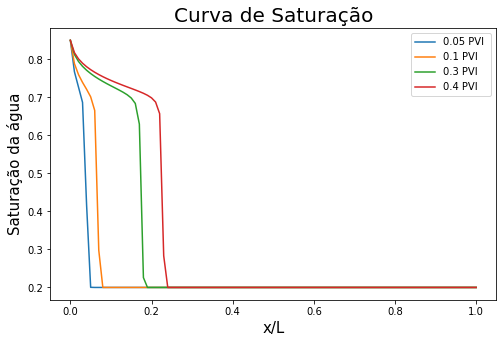

In [164]:
#plotar os resultados algoritmo II
matriz_resultado_saturacao_validacao_II = np.insert(matriz_resultado_saturacao_validacao_II, 0, values = sw_CC, axis=1) #Adicionando o ponto referente a condição de contorno
vetor_comprimento = np.linspace(0, 1, nx+1)
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_II[49], label = "0.05 PVI ") 
ax.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_II[99], label = "0.1 PVI")
ax.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_II[299], label = "0.3 PVI")
ax.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_II[399], label = "0.4 PVI")
#ax.plot(vetor_comprimento, matriz_resultado_saturacao[71], label = "0.432 PVI")

ax.set_xlabel("x/L", fontsize=15)
ax.set_ylabel("Saturação da água", fontsize=15)
plt.title("Curva de Saturação", fontsize=20)
ax.legend()
plt.show()

Comparação entre os algoritmos

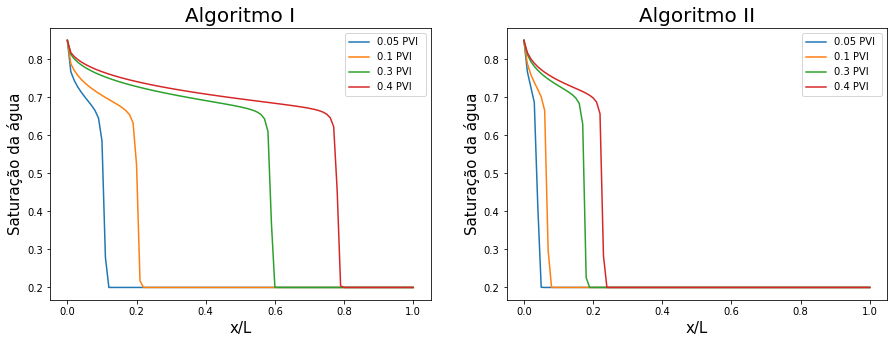

In [ ]:
#plotar os resultados dos dois algoritmos 
vetor_comprimento = np.linspace(0, 1, nx+1)
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

ax1.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_I[49], label = "0.05 PVI ") 
ax1.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_I[99], label = "0.1 PVI")
ax1.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_I[299], label = "0.3 PVI")
ax1.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_I[399], label = "0.4 PVI")

ax2.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_II[49], label = "0.05 PVI ") 
ax2.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_II[99], label = "0.1 PVI")
ax2.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_II[299], label = "0.3 PVI")
ax2.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_II[399], label = "0.4 PVI")

#configurações dos gráficos
ax1.set_xlabel("x/L", fontsize=15)
ax1.set_ylabel("Saturação da água", fontsize=15)
ax1.set_title("Algoritmo I", fontsize=20)
ax1.legend()

ax2.set_xlabel("x/L", fontsize=15)
ax2.set_ylabel("Saturação da água", fontsize=15)
ax2.set_title("Algoritmo II", fontsize=20)
ax2.legend()

plt.show()

In [178]:
matriz_resultado_saturacao_tvd = matriz_resultado_saturacao_two_point

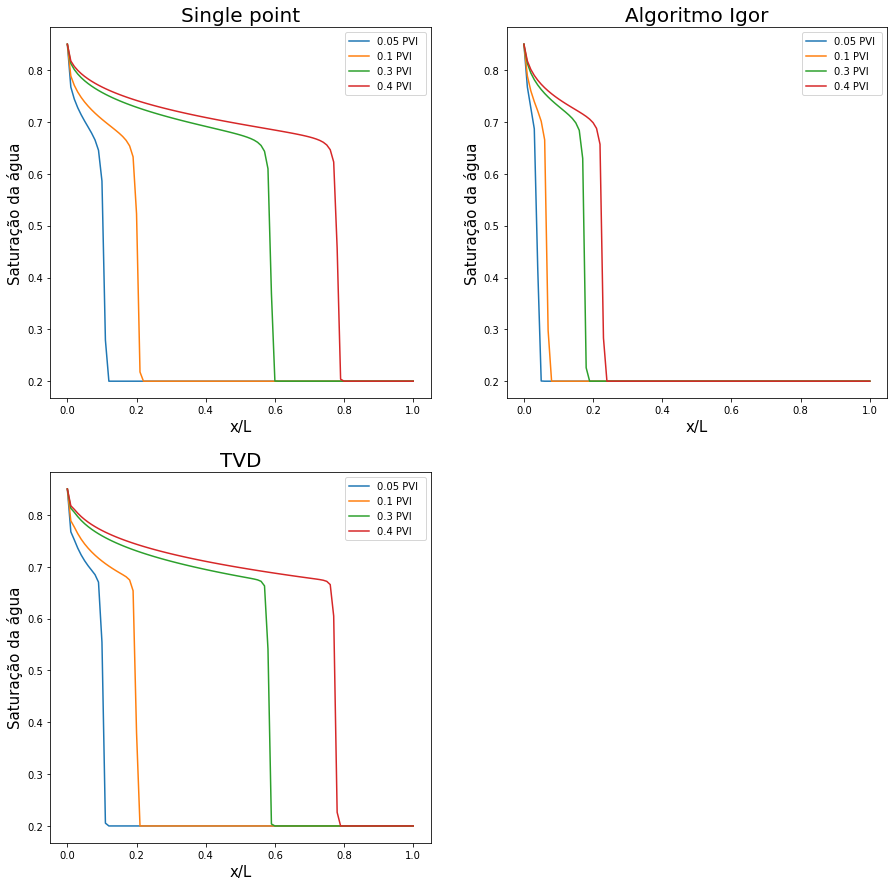

In [180]:
#plotar os resultados dos dois algoritmos 
vetor_comprimento = np.linspace(0, 1, nx+1)
fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)


ax1.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_I[49], label = "0.05 PVI ") 
ax1.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_I[99], label = "0.1 PVI")
ax1.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_I[299], label = "0.3 PVI")
ax1.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_I[399], label = "0.4 PVI")

ax2.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_II[49], label = "0.05 PVI ") 
ax2.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_II[99], label = "0.1 PVI")
ax2.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_II[299], label = "0.3 PVI")
ax2.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_II[399], label = "0.4 PVI")

ax3.plot(vetor_comprimento, matriz_resultado_saturacao_tvd[49], label = "0.05 PVI ") 
ax3.plot(vetor_comprimento, matriz_resultado_saturacao_tvd[99], label = "0.1 PVI")
ax3.plot(vetor_comprimento, matriz_resultado_saturacao_tvd[299], label = "0.3 PVI")
ax3.plot(vetor_comprimento, matriz_resultado_saturacao_tvd[399], label = "0.4 PVI")


#configurações dos gráficos
ax1.set_xlabel("x/L", fontsize=15)
ax1.set_ylabel("Saturação da água", fontsize=15)
ax1.set_title("Single point", fontsize=20)
ax1.legend()

ax2.set_xlabel("x/L", fontsize=15)
ax2.set_ylabel("Saturação da água", fontsize=15)
ax2.set_title("Algoritmo Igor", fontsize=20)
ax2.legend()

ax3.set_xlabel("x/L", fontsize=15)
ax3.set_ylabel("Saturação da água", fontsize=15)
ax3.set_title("TVD", fontsize=20)
ax3.legend()

plt.show()


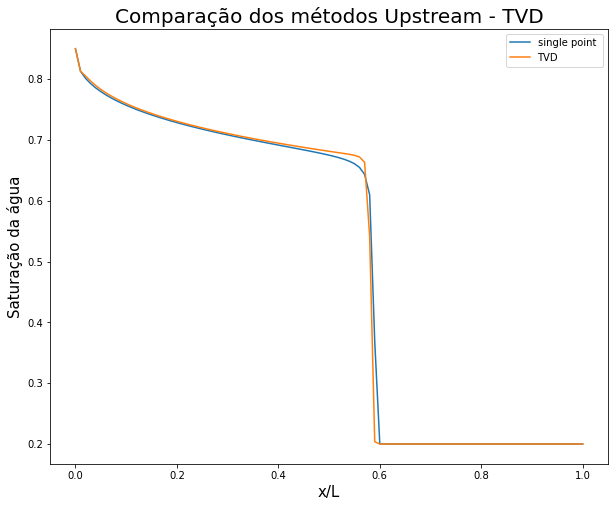

In [182]:
#plotar os resultados dos dois algoritmos 
vetor_comprimento = np.linspace(0, 1, nx+1)
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(1,1,1)

ax.plot(vetor_comprimento, matriz_resultado_saturacao_validacao_I[299], label = "single point ") 
ax.plot(vetor_comprimento, matriz_resultado_saturacao_tvd[299], label = "TVD")

#configurações dos gráficos
ax.set_xlabel("x/L", fontsize=15)
ax.set_ylabel("Saturação da água", fontsize=15)
ax.set_title("Comparação dos métodos Upstream - TVD", fontsize=20)
ax.legend()

plt.show()

### Solução analítica

In [ ]:
vetor_saturacao = np.arange(swi,1-sor,0.05)
vetor_saturacao

array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 ])

In [ ]:
kro, krw = perm_corey(vetor_saturacao,swi,sor,kro_swi,krw_sor,no,nw)

In [ ]:
kro

array([0.85      , 0.75909092, 0.67063051, 0.58478816, 0.50176491,
       0.42180406, 0.34520727, 0.27236062, 0.20377988, 0.14019772,
       0.08276035, 0.03361114, 0.        ])

In [ ]:
krw

array([0.        , 0.00208333, 0.00833333, 0.01875   , 0.03333333,
       0.05208333, 0.075     , 0.10208333, 0.13333333, 0.16875   ,
       0.20833333, 0.25208333, 0.3       ])

In [ ]:
fw = []
vetor = np.arange(13)
for i in vetor:
  fw.append(mobilidade(vetor_saturacao[i],visc_agua, visc_oleo))
  

In [ ]:
#fw = mobilidade(vetor_saturacao[1],visc_agua, visc_oleo)
fw

[array([0.]),
 array([0.00545906]),
 array([0.02424958]),
 array([0.06026147]),
 array([0.11728178]),
 array([0.19804651]),
 array([0.30290347]),
 array([0.42844696]),
 array([0.56683734]),
 array([0.70651374]),
 array([0.83428941]),
 array([0.93749994]),
 array([1.])]

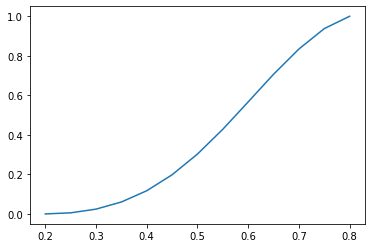

In [ ]:
plt.plot(vetor_saturacao, fw)

In [ ]:
dfw = [np.array(0)]
for i in range(len(fw)-1):
  dfw.append((fw[i+1]-fw[i])/dx)



In [ ]:
dfw

[array(0),
 array([0.5459057]),
 array([1.87905213]),
 array([3.60118932]),
 array([5.70203071]),
 array([8.07647304]),
 array([10.48569611]),
 array([12.55434901]),
 array([13.8390379]),
 array([13.96764018]),
 array([12.77756662]),
 array([10.32105341]),
 array([6.25000589])]

In [ ]:
td = ut*3000/(porosidade_meio*tam_meio_poroso)
xd = []
for i in range(len(dfw)):
  xd.append(td*dfw[i])  

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


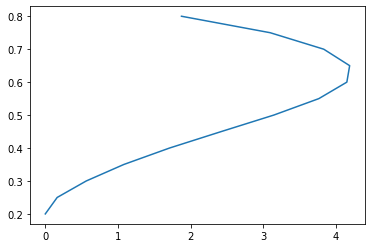

In [ ]:
plt.plot(xd,vetor_saturacao)

In [ ]:
xd[0] = np.array(0.0)
xd

[array(0.),
 array([0.16377171]),
 array([0.56371564]),
 array([1.0803568]),
 array([1.71060921]),
 array([2.42294191]),
 array([3.14570883]),
 array([3.7663047]),
 array([4.15171137]),
 array([4.19029205]),
 array([3.83326999]),
 array([3.09631602]),
 array([1.87500177])]